In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt 

In [2]:
#functions in order to create the bandids
def create_ranges(k, classing):
    """
    this method just create the reward range for every arm.
    those ranges are randomly generated.
    the function guarantees that every range is consist of a lower and an upper bound
    """
    ranges = [] #create a numpy array with len = k
    for i in range(k):
        lower = np.random.random() #a
        upper = np.random.random() #b
        (lower,upper) = (upper, lower) if upper < lower else (lower, upper) #in order to ensure that upper > lower
        e = .1 
        while ((upper+lower)/2 > e and  (upper+lower)/2 < 1-e and classing ): #creating arms that they belong in one class (either <e or > 1-e)
            lower = np.random.random()
            upper = np.random.random()
            (lower,upper) = (upper, lower) if upper < lower else (lower, upper) 
        for i in ranges: #ensuring that the ranges are unique (doesn't really needed because it is almost imposible)
          while(lower in i or upper in i):
            lower = np.random.random()
            upper = np.random.random()
            (lower,upper) = (upper, lower) if upper < lower else (lower, upper)
        ranges.append(np.array([lower, upper]))


    return np.array(ranges) 

def pull_arm(min, max):
  """method that returns a reward withing the given ranges"""
  return random.uniform(min, max)

def pull_and_update(arms, index, arms_score, arms_counter):
  """method responsible for updating the values in the storing arrays
  inputs: the armis going tipull and the arrays that the score and the visits of each arm are stored
  output: the mentioned arrays and the reward
  """
  arm = arms[index]
  (min, max)=arm[:]
  value = pull_arm(min, max)
  arms_score[index] = (arms_counter[index]*arms_score[index] + value)/(arms_counter[index]+1) #calulates the new mean
  arms_counter[index]+=1
  return (arms_score, arms_counter, value)


#method for debugging reasons
def print_list(l):
  for i,j in enumerate(l):
      print(f"{i}th element is {j}")

In [3]:
def epsilon_greedy(T, arms, best, k):
    eps = 1
    dt = .0001
    arms_score = np.zeros(len(arms)) #stores the mean per arm
    arms_counter = np.zeros(len(arms)) #stores the times that every arm was pulled 
    #variables in order to keep track of the regret
    regret = np.zeros((T))
    best_score = np.zeros((T))
    alg_score = np.zeros((T))
    for t in range(T):
        eps = (1/((t+dt)**(1/3)))*((k*np.log(t+dt))**(1/3)) if t ==0 else (1/((t)**(1/3)))*((k*np.log(t))**(1/3)) #dt was used only for t==0
        p = random.random()
        if eps < p: #pull an random arm
            index = random.randint(0, len(arms)-1 ) #selecting random arm 
            (arms_score, arms_counter, value) = pull_and_update(arms, index, arms_score, arms_counter)
        else : #pull the arm with the best mean
            index = np.argmax(arms_score) #selecting the "best" arm until that moment
            (arms_score, arms_counter, value) = pull_and_update(arms, index, arms_score, arms_counter)
        #calculating the regret
        best_score[t] =best_score[t-1]+ best if t>0 else best
        alg_score[t] = alg_score[t-1]+ value if t>0 else value
        regret[t] = (best_score[t] - alg_score[t])/(t+1)
    return np.argmax(arms_score), regret, alg_score

In [6]:
def ucb(T, arms, k, best):
    arms_score = np.zeros(len(arms)) #stores the mean per arm
    arms_counter = np.zeros(len(arms)) #stores the times that every arm was pulled 
    #variables in order to keep track of the regret
    regret = np.zeros(T)
    best_score = np.zeros(T)
    alg_score = np.zeros(T)
    #initial k rounds that explores every arm for the first time
    #in order to "initialize" the counter to 1
    for i in range(k):
        (arms_score, arms_counter, value) = pull_and_update(arms, i, arms_score, arms_counter)
        #updating "counters" for regret
        best_score[i] =best_score[i-1] + best if i>0 else best
        alg_score[i] = alg_score[i-1] + value if i>0 else value
        regret[i] = (best_score[i] - alg_score[i])/(i+1)
    #the "main" algorithm
    for i in range(k,T):
        index = arg_max_ucb(arms_score, arms_counter, i) #choose arm based on the max ucb
        (arms_score, arms_counter, value) = pull_and_update(arms, index, arms_score, arms_counter)
        #updating "counters" for regret
        best_score[i] =best_score[i-1] + best
        alg_score[i] = alg_score[i-1] + value
        regret[i] = (best_score[i] - alg_score[i])/(i+1)

    return np.argmax(arms_score), regret, alg_score

def arg_max_ucb(reward, q, t):
    """"
    this method just calculates the ucb
    of every arm and returns the index of the
    arm with the biggest ucb
    inputs: 
    reward: the list with the average reward per arm,
    q: the list with the counters that the algorith has "visit" every arm 
    outputs:
    the arm with the biggest ucb (so the arm tha is going to be selected)
    """
    ucb_array = []
    for r,n in zip(reward, q):
        ucb_array.append(r+np.sqrt(np.log(t)/n))
    return np.argmax(np.array(ucb_array))

<ipython-input-3-35a518d2ff54>:11: RuntimeWarning: invalid value encountered in double_scalars
  eps = (1/((t+dt)**(1/3)))*((k*np.log(t+dt))**(1/3)) if t ==0 else (1/((t)**(1/3)))*((k*np.log(t))**(1/3)) #dt was used only for t==0


best arm is 8
best arm based on e greedy is 8
best arm based on ucb is 8


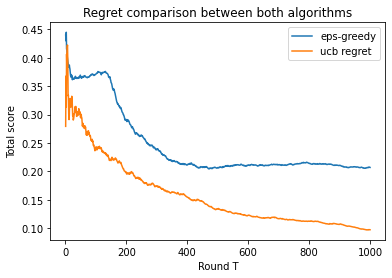

-----------------------------------------------


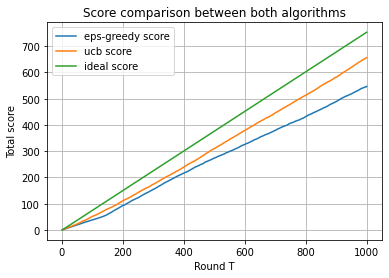

In [11]:
#main section
#creating the environment
k = 10
T = 100*k

#initialize/defining the range of rewards per arm
#and calculate the best arm
bandit = create_ranges(k, False) #creating the arms, False stands for not performing the classing experiment
#finding the best arm based on the mean
means = map(lambda x: (x[0]+x[1])/2, bandit)
means = list(means)
best = np.argmax(np.array(means))
ideal_reward=list([i*means[best] for i in range(T)]) #calculating ideal reward just in order to plot it
#apply the two algorithm
best_arm_egreedy, eps_greedy_regret, eps_alg_score = epsilon_greedy(T, bandit, means[best], k)
best_arm_ucb, ucb_regret, ucb_alg_score = ucb(T, bandit, k, means[best])

#printing/plotting results
print(f"best arm is {best}")
print(f"best arm based on e greedy is {best_arm_egreedy}")
print(f"best arm based on ucb is {best_arm_ucb}")


#graphs section 
plt.figure(1)
plt.title("Regret comparison between both algorithms") 
plt.xlabel("Round T") 
plt.ylabel("Total score") 
plt.plot(np.arange(1,T+1),eps_greedy_regret, label="eps-greedy") 
plt.plot(np.arange(1,T+1),ucb_regret, label="ucb regret") 
plt.legend()
plt.show()
print("-----------------------------------------------")
#
plt.figure(2)
plt.title("Score comparison between both algorithms") 
plt.xlabel("Round T") 
plt.ylabel("Total score") 
plt.plot(np.arange(1,T+1),eps_alg_score, label="eps-greedy score") 
plt.plot(np.arange(1,T+1),ucb_alg_score, label="ucb score") 
plt.plot(np.arange(1,T+1),ideal_reward, label="ideal score") 
plt.grid()
plt.legend()
plt.show()
